# Optimizations of ZOEE to HadCM3, CESM, Pages2k

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ZOEE.modules.configuration import importer, add_sellersparameters, parameterinterpolatorstepwise
from ZOEE.modules.variables import variable_importer, Vars, Base
from ZOEE.modules.optimization import optimization, ZOEE_optimization
#from ZOEE import update_plotstyle, moving_average
from ZOEE.modules.rk4 import rk4alg
#import matplotlib
#update_plotstyle()
#matplotlib.rcParams['lines.linewidth']=1.1

## General optimization setup

In [3]:
Lat_10,ZMT_10=np.loadtxt('ZOEE_transition/Data/ERA_ZMT_Mean_10deginterpolated.txt')

In [4]:
"""Decleration of optimization configuration"""
grid=np.linspace(-85,85,18)
optimization_setup = optimization(mode='Coupled',
                            target=None,
                            response=True, 
                            num_steps=20,
                            num_data=12000,
                            gamma0=1e-8,
                            cost_function_type='LeastSquare',
                            cost_ratio=0.2,
                            ZMT=ZMT_10,
                            GMT=288.15,
                            precision=0,
                            grid=grid)

"""Declaration of parameter setup, with initial parameters, parameter boundaries and 
the parameter pertubation to estimate the cost function gradient"""
P0=np.array([70*4.2e6,200,1.9,1.165,1.165,1.165])
#P0=Get_PGamma[0]
Pmin=np.array([1*4.2e6,170,1.1,0.9,0.9,0.9])
Pmax=np.array([100*4.2e6,240,2.5,1.3,1.3,1.3])
P_pert_ratio=1/10000
optimization_setup.give_parameters(P0,Pmin,Pmax,P_pert_ratio)
        

# HadCM3

In [10]:
HadCM3_GMT=np.loadtxt('Experiments/HadCM3/HadCM3_850_1850.txt',delimiter=',')

In [11]:
config_HadCM3=importer('Experiments/Tests/Config_HadCM3.ini')
#parallel_config = {'number_of_parameters': 6, 'number_of_cycles': 1,'number_of_parallels': 13}
variable_importer(config_HadCM3,initialZMT=True,parallel=False,control=True)
config_HadCM3,Sellers=add_sellersparameters(config_HadCM3, parameterinterpolatorstepwise,\
                                            'ZOEE_transition/Data/SellersParameterization.ini',4,2,True,True)
CTRL_HadCM3 = rk4alg(config_HadCM3, progressbar=True, monthly=True)

Vars.T = CTRL_HadCM3[1][-1]
variable_importer(config_HadCM3,initialZMT=False,parallel=False,control=False)
#Base.number_of_integration=2*365
HadCM3 = rk4alg(config_HadCM3, progressbar=True, monthly=True)


Loading Configuration from: Experiments/Tests/Config_HadCM3.ini
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.
Loading Parameters from: ZOEE_transition/Data/SellersParameterization.ini


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Eq. State reached after 54053 steps, within 62.57829451560974 seconds


HBox(children=(IntProgress(value=0, max=365000), HTML(value='')))

In [34]:
from ZOEE.modules.functions import cosd
optimization_test=optimization(mode='Coupled',
                            target=None,
                            response=True, 
                            num_steps=1,
                            num_data=12000,
                            gamma0=1e-8,
                            cost_function_type='LeastSquare',
                            cost_ratio=0.3,
                            ZMT=ZMT_10,
                            GMT=288.15,
                            precision=0,
                            grid=grid)
optimization_test.parallels=3
print(optimization_test.target_comparison(np.tile(HadCM3[2][1:]+np.average(elevation, weights=cosd(Vars.Lat)),(3,1)),'GMT',HadCM3_GMT[1]))
print(optimization_test.target_comparison(HadCM3[2][1:],'GMT',HadCM3_GMT[1]))

[413.68973559 413.68973559 413.68973559]
[33428.80871341 33431.65189288 33436.22411479]


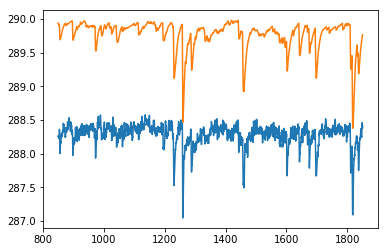

In [25]:
#plt.plot(Vars.Lat,HadCM3[1][-1]+elevation)
#plt.plot(Lat_10,ZMT_10)
plt.plot(HadCM3_GMT[0],HadCM3_GMT[1])
plt.plot(HadCM3[0][1:]/(365*86400),HadCM3[2][1:]+np.average(elevation, weights=cosd(Vars.Lat)))
#plt.scatter()
#print(np.average(HadCM3[1][-1]+elevation,weights=cosd(Vars.Lat)))
#print(np.mean(HadCM3[2][1:]+np.average(elevation, weights=cosd(Vars.Lat))))

In [37]:
"""Import the configuration that is required to run your specific model"""

config_HadCM3=importer('Experiments/HadCM3/Config_HadCM3.ini')
parallel_config = {'number_of_parameters': 6, 'number_of_cycles': 1,'number_of_parallels': 13}
variable_importer(config_HadCM3,initialZMT=False,parallel=True,parallel_config=parallel_config)
config_HadCM3,Sellers=add_sellersparameters(config_HadCM3, parameterinterpolatorstepwise,\
                                            'ZOEE_transition/Data/SellersParameterization.ini',4,2,True,True)


"""Import the class of your model that has to be defined in ZOEE.modules.optimization. And give it whatever 
configuration it requires"""

parameter_labels=[['eqparam','c_ao'],['func3','a'],['func3','b'],['func4','factor_oc'],['func4','factor_kwv'],['func4','factor_kair']]
parameter_levels=np.array([None,None,None,None,None,None])
elevation=-0.0065*np.array(Sellers[1][1])
ZOEE_HadCM3 = ZOEE_optimization(6,'Coupled',parameter_labels,parameter_levels,True,elevation,monthly=True)
#model_setup=[2,'ZMT',parameter_labels,parameter_levels,elevation,True]

"""Execture optimize to start the optimization, giving it your model imported in the step before and configuration
required to run your model"""
optimization_setup.target={'ZMT':ZMT_10,'GMT':HadCM3_GMT[1]}
optimization_setup.num_data=12000
optimization_setup.response=False
F_HadCM3, dF_HadCM3, P_HadCM3, Ptrans_HadCM3, gamma_HadCM3, data_HadCM3=optimization_setup.optimize(ZOEE_HadCM3,config_HadCM3)

Loading Configuration from: Experiments/HadCM3/Config_HadCM3.ini
Loading Parameters from: ZOEE_transition/Data/SellersParameterization.ini


HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

Iteration no.0
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

/home/benni/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


Eq. State reached after 52051 steps, within 264.68624997138977 seconds


HBox(children=(IntProgress(value=0, max=365000), HTML(value='')))

[481.95537951 481.94793153 481.96272305 462.63812811 502.04194545
 476.24448091 487.73106575 482.06486521 481.84594282 481.98578124
 481.92481489 482.40934328 481.50162482]
1e-08
[2.94000000e+08 1.99998030e+02 1.89942567e+00 1.16501095e+00
 1.16500305e+00 1.16504539e+00]
Iteration no.1
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Eq. State reached after 50049 steps, within 240.9284896850586 seconds


HBox(children=(IntProgress(value=0, max=365000), HTML(value='')))

[453.1682287  453.16110995 453.17525408 435.0067256  472.10016322
 447.7930912  458.60852385 453.27136659 453.06496196 453.19696519
 453.13944924 453.59571897 452.74100413]
1.7116863059781544e-07
[2.94000000e+08 1.99966284e+02 1.89016936e+00 1.16518760e+00
 1.16505227e+00 1.16577689e+00]
Iteration no.2
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Eq. State reached after 50049 steps, within 230.8924732208252 seconds


HBox(children=(IntProgress(value=0, max=365000), HTML(value='')))

[232.18840322 232.18613211 232.19083302 232.94165373 232.21611462
 232.37185612 232.07411405 232.18672878 232.19025352 232.1879499
 232.18893431 232.18176605 232.19578991]
1.667215654710972e-07
[2.94000000e+08 1.99966888e+02 1.89041756e+00 1.16518466e+00
 1.16505145e+00 1.16576520e+00]
Iteration no.3
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Eq. State reached after 50049 steps, within 230.57217240333557 seconds


HBox(children=(IntProgress(value=0, max=365000), HTML(value='')))

[232.0409736  232.03832934 232.04353167 232.31003146 232.55217982
 232.0805915  232.07004548 232.04179604 232.03998926 232.04126679
 232.04068226 232.0452618  232.03698904]
1.6774110504242714e-07
[2.94000000e+08 1.99966685e+02 1.89042640e+00 1.16518617e+00
 1.16505194e+00 1.16577214e+00]
Iteration no.4
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Eq. State reached after 50049 steps, within 231.25095653533936 seconds


HBox(children=(IntProgress(value=0, max=365000), HTML(value='')))

[232.03650776 232.03395925 232.03898649 232.31685332 232.53625694
 232.07932376 232.06207563 232.0373002  232.03558618 232.0367835
 232.03623389 232.04038285 232.03270621]
1.9490970870078963e-08
[2.94000000e+08 1.99966664e+02 1.89042808e+00 1.16518634e+00
 1.16505200e+00 1.16577288e+00]
Iteration no.5
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Eq. State reached after 50049 steps, within 231.9693262577057 seconds


HBox(children=(IntProgress(value=0, max=365000), HTML(value='')))

[232.03598895 232.03344039 232.03846771 232.31629147 232.53577861
 232.07879222 232.06156932 232.03685821 232.03506713 232.03626474
 232.03571501 232.03986495 232.03218645]
3.625145614870312e-07
[2.94000000e+08 1.99966266e+02 1.89045930e+00 1.16518959e+00
 1.16505299e+00 1.16578680e+00]
Iteration no.6
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Eq. State reached after 50049 steps, within 231.48976826667786 seconds


HBox(children=(IntProgress(value=0, max=365000), HTML(value='')))

[232.02633659 232.02378728 232.0288927  232.30594783 232.52684658
 232.06927361 232.05219403 232.02728607 232.0254111  232.0266134
 232.02606163 232.03030382 232.02261207]
2.498280009524951e-06
[2.94000000e+08 1.99963507e+02 1.89067265e+00 1.16521301e+00
 1.16505989e+00 1.16588288e+00]
Iteration no.7
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Eq. State reached after 50049 steps, within 233.1705710887909 seconds


HBox(children=(IntProgress(value=0, max=365000), HTML(value='')))

[231.96000584 231.95745266 231.96248925 232.24013932 232.45986979
 232.00297453 231.98583986 231.96087544 231.95908372 231.96028171
 231.95973183 231.96406704 231.95646574]
0.0001272029403587165
[2.94000000e+08 1.99823755e+02 1.90157055e+00 1.16635257e+00
 1.16540961e+00 1.17071742e+00]
Iteration no.8
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Eq. State reached after 50049 steps, within 230.9546914100647 seconds


HBox(children=(IntProgress(value=0, max=365000), HTML(value='')))

[228.68963198 228.68683606 228.69243461 228.79778963 229.34572697
 228.68192379 228.76499586 228.69145236 228.68783469 228.69015021
 228.68911553 228.69730348 228.68260139]
1.164353553445613e-05
[2.94000000e+08 1.99791855e+02 1.89673429e+00 1.16656318e+00
 1.16546985e+00 1.17157335e+00]
Iteration no.9
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Eq. State reached after 50049 steps, within 231.68079090118408 seconds


HBox(children=(IntProgress(value=0, max=365000), HTML(value='')))

[316.44968804 316.44998658 316.44939638 328.36814963 305.3008684
 319.97434385 312.99476638 316.38658189 316.51281676 316.43215154
 316.4672263  316.18889998 316.71086236]
1.5020695066112543e-07
[2.94000000e+08 1.99809180e+02 1.90197619e+00 1.16646837e+00
 1.16544351e+00 1.17118133e+00]
Iteration no.10
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Eq. State reached after 49048 steps, within 226.65820455551147 seconds


HBox(children=(IntProgress(value=0, max=365000), HTML(value='')))

[229.01105986 229.00855032 229.01357613 230.26657867 228.51938691
 229.34438316 228.74528097 229.00657484 229.01556786 229.00982382
 229.01229768 228.99247888 229.03002426]
1.6413166290782196e-07
[2.94000000e+08 1.99810614e+02 1.90246785e+00 1.16646099e+00
 1.16544148e+00 1.17115052e+00]
Iteration no.11
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Eq. State reached after 49048 steps, within 226.6763105392456 seconds


HBox(children=(IntProgress(value=0, max=365000), HTML(value='')))

[228.37860679 228.37584073 228.38137958 228.66602009 228.85400503
 228.4239771  228.40041258 228.37943565 228.37780095 228.37884908
 228.37836629 228.3819658  228.37543756]
1.685609654270363e-07
[2.94000000e+08 1.99810455e+02 1.90248771e+00 1.16646237e+00
 1.16544189e+00 1.17115602e+00]
Iteration no.12
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Eq. State reached after 49048 steps, within 226.22751641273499 seconds


HBox(children=(IntProgress(value=0, max=365000), HTML(value='')))

[228.37449334 228.37172377 228.37711656 228.64954953 228.86214235
 228.41619171 228.39996711 228.37523688 228.37361977 228.37475447
 228.374234   228.37809449 228.37095365]
3.5084390483357736e-07
[2.94000000e+08 1.99810082e+02 1.90251617e+00 1.16646521e+00
 1.16544280e+00 1.17116855e+00]
Iteration no.13
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Eq. State reached after 49048 steps, within 227.27559995651245 seconds


HBox(children=(IntProgress(value=0, max=365000), HTML(value='')))

[228.36593146 228.36316145 228.36870817 228.64128201 228.85332288
 228.40771809 228.39131349 228.36682629 228.36505963 228.36619209
 228.3656726  228.36960126 228.36256612]
2.7027827768538774e-06
[2.94000000e+08 1.99807217e+02 1.90273786e+00 1.16648908e+00
 1.16544982e+00 1.17126362e+00]
Iteration no.14
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Eq. State reached after 49048 steps, within 226.75409865379333 seconds


HBox(children=(IntProgress(value=0, max=365000), HTML(value='')))

[228.30050342 228.29772881 228.30346541 228.57313103 228.79066266
 228.34169733 228.32688362 228.30141279 228.29979774 228.30076809
 228.30033087 228.30441207 228.29724661]
1.579458986386038e-05
[2.94000000e+08 1.99790038e+02 1.90390775e+00 1.16661663e+00
 1.16548435e+00 1.17182950e+00]
Iteration no.15
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Eq. State reached after 49048 steps, within 226.48496460914612 seconds


HBox(children=(IntProgress(value=0, max=365000), HTML(value='')))

[227.95635337 227.95369563 227.95901785 228.46528444 228.20864822
 228.06766118 227.91243255 227.95588274 227.95684696 227.95617821
 227.95645302 227.95477506 227.95841278]
7.67146630141549e-07
[2.94000000e+08 1.99791022e+02 1.90450316e+00 1.16661293e+00
 1.16548329e+00 1.17181555e+00]
Iteration no.16
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Eq. State reached after 49048 steps, within 227.60920596122742 seconds


HBox(children=(IntProgress(value=0, max=365000), HTML(value='')))

[228.36659473 228.36372866 228.36962238 227.80080014 229.69251384
 228.15859484 228.64163379 228.37209362 228.36127375 228.36813613
 228.36513258 228.38936998 228.34427642]
1.771131618496384e-07
[2.94000000e+08 1.99789347e+02 1.90407540e+00 1.16662251e+00
 1.16548595e+00 1.17185548e+00]
Iteration no.17
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Eq. State reached after 49048 steps, within 227.16532921791077 seconds


HBox(children=(IntProgress(value=0, max=365000), HTML(value='')))

[227.89952577 227.89674067 227.90224003 228.22437866 228.33534265
 227.95618344 227.91012956 227.90006305 227.89893384 227.89970836
 227.89934494 227.90203889 227.89741618]
1.6432026746320957e-07
[2.94000000e+08 1.99789256e+02 1.90411324e+00 1.16662344e+00
 1.16548625e+00 1.17185928e+00]
Iteration no.18
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Eq. State reached after 49048 steps, within 227.46669054031372 seconds


HBox(children=(IntProgress(value=0, max=365000), HTML(value='')))

[227.89400976 227.89121127 227.89681495 228.16933346 228.37912451
 227.93588292 227.9192089  227.89481809 227.8931467  227.89426778
 227.8937535  227.89755561 227.89069034]
2.1382215042603963e-07
[2.94000000e+08 1.99789031e+02 1.90413106e+00 1.16662522e+00
 1.16548680e+00 1.17186662e+00]
Iteration no.19
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Eq. State reached after 49048 steps, within 227.05499362945557 seconds


HBox(children=(IntProgress(value=0, max=365000), HTML(value='')))

In [48]:
np.savetxt('Experiments/Output/HadCM3_P_20.txt',[P_HadCM3[-1],np.tile(gamma_HadCM3[-1],6)],delimiter=',')
np.savetxt('Experiments/Output/HadCM3_F_20.txt',F_HadCM3,delimiter=',')
np.savetxt('Experiments/Output/HadCM3_F_20.txt',dF_HadCM3,delimiter=',')
np.savetxt('Experiments/Output/HadCM3_ZMT_20.txt',data_HadCM3[0][:,0],delimiter=',')
np.savetxt('Experiments/Output/HadCM3_GMT_20.txt',data_HadCM3[1][:,0],delimiter=',')

# CESM

In [58]:
CESM_GMT=np.loadtxt('Experiments/CESM/CESM_850_1850.txt',delimiter=',')

In [5]:
config_CESM=importer('Experiments/CESM/Config_CESM.ini')
#parallel_config = {'number_of_parameters': 6, 'number_of_cycles': 1,'number_of_parallels': 13}
variable_importer(config_CESM,initialZMT=True,parallel=False,control=True)
config_CESM,Sellers=add_sellersparameters(config_CESM, parameterinterpolatorstepwise,\
                                            'ZOEE_transition/Data/SellersParameterization.ini',4,2,True,True)
CTRL_CESM = rk4alg(config_CESM, progressbar=True, monthly=True)

Vars.solar
#Vars.T = CTRL_CESM[1][-1]
#variable_importer(config_CESM,initialZMT=False,parallel=False,control=False)
#Base.number_of_integration=10*365
#CESM = rk4alg(config_CESM, progressbar=True, monthly=True)


Loading Configuration from: Experiments/CESM/Config_CESM.ini
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.
Loading Parameters from: ZOEE_transition/Data/SellersParameterization.ini


/home/benni/.local/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


Eq. State reached after 54053 steps, within 63.044265031814575 seconds



array([173.83724949, 185.65844211, 213.72606851, 260.34318977,
       306.98035773, 347.85123454, 380.30298506, 402.73909003,
       414.1902869 , 414.19028694, 402.73909016, 380.30298529,
       347.85123484, 306.9803581 , 260.34319021, 213.72606899,
       185.65844262, 173.83725002])

In [79]:
Vars.ExternalOutput

array([[-0.0513, -0.04545, -0.04005, ..., 0, 0, 0]], dtype=object)

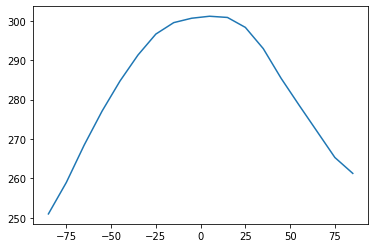

In [6]:
plt.plot(Vars.Lat,CTRL_CESM[1][-1])
#plt.plot(CESM[0],CESM[2])

In [ ]:
"""Import the configuration that is required to run your specific model"""

config_CESM=importer('Experiments/CESM/Config_CESM.ini')
parallel_config = {'number_of_parameters': 6, 'number_of_cycles': 1,'number_of_parallels': 13}
variable_importer(config_CESM,initialZMT=False,parallel=True,parallel_config=parallel_config)
config_CESM,Sellers=add_sellersparameters(config_CESM, parameterinterpolatorstepwise,\
                                            'ZOEE_transition/Data/SellersParameterization.ini',4,2,True,True)


"""Import the class of your model that has to be defined in ZOEE.modules.optimization. And give it whatever 
configuration it requires"""

parameter_labels=[['eqparam','c_ao'],['func3','a'],['func3','b'],['func4','factor_oc'],['func4','factor_kwv'],['func4','factor_kair']]
parameter_levels=np.array([None,None,None,None,None,None])
elevation=-0.0065*np.array(Sellers[1][1])
ZOEE_CESM = ZOEE_optimization(6,'Coupled',parameter_labels,parameter_levels,elevation,monthly=True)
#model_setup=[2,'ZMT',parameter_labels,parameter_levels,elevation,True]

"""Execture optimize to start the optimization, giving it your model imported in the step before and configuration
required to run your model"""
optimization_setup.target={'ZMT':ZMT_10,'GMT':CESM_GMT}
optimization_setup.num_data=1000
optimization_setup.response=False
F_CESM, dF_CESM, P_CESM, Ptrans_CESM, gamma_CESM, data_CESM=optimization_setup.optimize(ZOEE_CESM,config_CESM)

In [ ]:
np.savetxt('Experiments/Output/CESM_P_20.txt',[P_CESM[-1],np.tile(gamma_CESM,6)],delimiter=',')
np.savetxt('Experiments/Output/CESM_F_20.txt',[F_CESM[-1],dF_CESM],delimiter=',')
np.savetxt('Experiments/Output/CESM_ZMT_20.txt',data_CESM[0][:,0],delimiter=',')
np.savetxt('Experiments/Output/CESM_GMT_20.txt',data_CESM[1][:,0],delimiter=',')

# Pages2k

In [85]:
Pages_GMT=np.loadtxt('Experiments/Pages2k/Pages2k_850_1850.txt',delimiter=',')

In [87]:
config_Pages=importer('Experiments/Pages2k/Config_Pages.ini')
#parallel_config = {'number_of_parameters': 6, 'number_of_cycles': 1,'number_of_parallels': 13}
variable_importer(config_Pages,initialZMT=True,parallel=False,control=True)
config_Pages,Sellers=add_sellersparameters(config_Pages, parameterinterpolatorstepwise,\
                                            'ZOEE_transition/Data/SellersParameterization.ini',4,2,True,True)
CTRL_Pages = rk4alg(config_Pages, progressbar=True, monthly=True)

Vars.solar
#Vars.T = CTRL_CESM[1][-1]
#variable_importer(config_CESM,initialZMT=False,parallel=False,control=False)
#Base.number_of_integration=10*365
#CESM = rk4alg(config_CESM, progressbar=True, monthly=True)


Loading Configuration from: Experiments/Pages2k/Config_Pages.ini
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.
Loading Parameters from: ZOEE_transition/Data/SellersParameterization.ini


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

/home/benni/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


Eq. State reached after 54053 steps, within 62.716979026794434 seconds


array([173.83088714, 185.6516471 , 213.71824624, 260.33366135,
       306.96912241, 347.83850337, 380.28906618, 402.72434999,
       414.17512775, 414.1751278 , 402.72435013, 380.2890664 ,
       347.83850367, 306.96912278, 260.33366179, 213.71824673,
       185.65164762, 173.83088767])

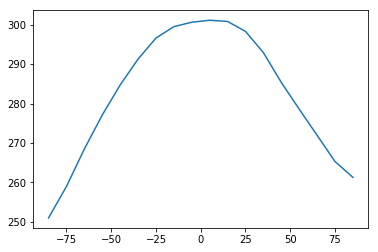

In [88]:
plt.plot(Vars.Lat,CTRL_Pages[1][-1])

In [ ]:
"""Import the configuration that is required to run your specific model"""

config_Pages=importer('Experiments/Pages2k/Config_Pages.ini')
parallel_config = {'number_of_parameters': 6, 'number_of_cycles': 1,'number_of_parallels': 13}
variable_importer(config_Pages,initialZMT=False,parallel=True,parallel_config=parallel_config)
config_Pages,Sellers=add_sellersparameters(config_Pages, parameterinterpolatorstepwise,\
                                            'ZOEE_transition/Data/SellersParameterization.ini',4,2,True,True)


"""Import the class of your model that has to be defined in ZOEE.modules.optimization. And give it whatever 
configuration it requires"""

parameter_labels=[['eqparam','c_ao'],['func3','a'],['func3','b'],['func4','factor_oc'],['func4','factor_kwv'],['func4','factor_kair']]
parameter_levels=np.array([None,None,None,None,None,None])
elevation=-0.0065*np.array(Sellers[1][1])
ZOEE_Pages = ZOEE_optimization(6,'Coupled',parameter_labels,parameter_levels,elevation,monthly=False)
#model_setup=[2,'ZMT',parameter_labels,parameter_levels,elevation,True]

"""Execture optimize to start the optimization, giving it your model imported in the step before and configuration
required to run your model"""
optimization_setup.target={'ZMT':ZMT_10,'GMT':Pages_GMT}
optimization_setup.num_data=12000
optimization_setup.response=True
F_Pages, dF_Pages, P_Pages, Ptrans_Pages, gamma_Pages, data_Pages=optimization_setup.optimize(ZOEE_Pages,config_Pages)

In [ ]:
np.savetxt('Experiments/Output/Pages_P_20.txt',[P_Pages[-1],np.tile(gamma_Pages,6)],delimiter=',')
np.savetxt('Experiments/Output/Pages_F_20.txt',[F_Pages[-1],dF_Pages],delimiter=',')
np.savetxt('Experiments/Output/Pages_ZMT_20.txt',data_Pages[0][:,0],delimiter=',')
np.savetxt('Experiments/Output/Pages_GMT_20.txt',data_Pages[1][:,0],delimiter=',')

In [ ]:
x=np.array([[2,2],[2,2],[2,2]])
(x-np.array([2,2])).shape